In [207]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn 
import numpy as np
import torch
from scipy.stats import ttest_ind

In [ ]:
target_metric = 'MRR'
partition = 'valid'
alpha = 0.15
group_relation_directions = False # so _fwd and _rev edges will be listed as having the same relation type

In [209]:
def remove_dir(rel): 
    rel = rel.split('->')[1]
    if rel.endswith('_fwd') or rel.endswith('_rev'):
        return rel[:-4]
    else: 
        return rel

In [210]:
cpx_res = pd.read_csv(f'/home/teddy/local/TKG-DTI/output/ablation/tkge/COMPLEX2/{partition}_metrics.csv')
gnn_res = pd.read_csv(f'/home/teddy/local/TKG-DTI/output/ablation/tkge/GNN/{partition}_metrics.csv')
data = torch.load('/home/teddy/local/TKG-DTI/data/tkg/processed/FOLD_0/Data.pt', weights_only=False)

print('# entries (COMPLEX2):', cpx_res.shape[0])
print('# entries (GNN):', gnn_res.shape[0])

rel2int = {k:v[0] for k,v in data.edge_reltype.items()} 
int2rel = {v:'->'.join(k) for k,v in rel2int.items()}

if group_relation_directions: 
    int2rel = {k:remove_dir(v) for k,v in int2rel.items()}

cpx_res = cpx_res.assign(remove_relation = cpx_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))
gnn_res = gnn_res.assign(remove_relation = gnn_res.remove_relation_idx.apply(lambda x: int2rel.get(x, 'None')))

all_cpx = cpx_res.copy()
all_gnn = gnn_res.copy()

# entries (COMPLEX2): 133
# entries (GNN): 157


In [211]:
cpx_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]} 

for rel in cpx_res.remove_relation.unique():

    x = cpx_res[cpx_res.remove_relation == 'None'][target_metric].values
    y = cpx_res[cpx_res.remove_relation == rel][target_metric].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    cpx_pval['remove_relation'].append(rel)
    cpx_pval['pval'].append(pval)
    cpx_pval['tstat'].append(tstat)
    cpx_pval['nx'].append(nx)
    cpx_pval['ny'].append(ny)

cpx_pval = pd.DataFrame(cpx_pval)

In [212]:
gnn_pval = {'remove_relation':[], 'pval':[], 'tstat':[], 'nx':[], 'ny':[]}

for rel in gnn_res.remove_relation.unique():

    x = gnn_res[gnn_res.remove_relation == 'None'][target_metric].values
    y = gnn_res[gnn_res.remove_relation == rel][target_metric].values

    nx = len(x)
    ny = len(y)

    tstat, pval = ttest_ind(x, y, equal_var=False)

    gnn_pval['remove_relation'].append(rel)
    gnn_pval['pval'].append(pval)
    gnn_pval['tstat'].append(tstat)
    gnn_pval['nx'].append(nx)
    gnn_pval['ny'].append(ny)

gnn_pval = pd.DataFrame(gnn_pval)

In [213]:
cpx_res = cpx_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
cpx_none = cpx_res.loc[cpx_res.remove_relation == 'None']
cpx_deltas = cpx_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - cpx_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
cpx_deltas.columns = [f'{c}_delta' for c in cpx_deltas.columns]
cpx_res = pd.concat([cpx_res, cpx_deltas], axis=1)
cpx_res = cpx_res.merge(cpx_pval, on='remove_relation', how='left')

gnn_res = gnn_res[['remove_relation', 'MRR', 'avg_AUC', 'Top1', 'Top3']].groupby('remove_relation').mean().reset_index()
gnn_none = gnn_res.loc[gnn_res.remove_relation == 'None']
gnn_deltas = gnn_res[['MRR', 'avg_AUC', 'Top1', 'Top3']] - gnn_none[['MRR', 'avg_AUC', 'Top1', 'Top3']].values
gnn_deltas.columns = [f'{c}_delta' for c in gnn_deltas.columns]
gnn_res = pd.concat([gnn_res, gnn_deltas], axis=1)
gnn_res = gnn_res.merge(gnn_pval, on='remove_relation', how='left')

cpx_res = cpx_res.assign(model='COMPLEX2')
gnn_res = gnn_res.assign(model='GNN') 
res = pd.concat([cpx_res, gnn_res], axis=0)
res = res.sort_values(by=target_metric, ascending=False)
res = res.assign(detrimental = res.tstat < 0)
                         
res.head()

,remove_relation,MRR,avg_AUC,Top1,Top3,MRR_delta,avg_AUC_delta,Top1_delta,Top3_delta,pval,tstat,nx,ny,model,detrimental
13,chemberta_cosine_similarity,0.202905,0.952655,0.126033,0.219008,0.014024,0.014063,0.012397,0.017769,0.351351,-1.500012,10,2,COMPLEX2,True
21,predicted_weak_binding,0.197179,0.932649,0.123278,0.201102,0.008299,-0.005943,0.009642,-0.000138,0.122948,-1.716617,10,6,COMPLEX2,True
6,NPC_lincs_perturbation,0.196093,0.941786,0.120661,0.208264,0.007213,0.003194,0.007025,0.007025,0.089712,-1.895246,10,5,COMPLEX2,True
2,ASC_lincs_perturbation,0.196068,0.939290,0.117355,0.213223,0.007188,0.000698,0.003719,0.011983,0.126135,-1.708139,10,5,COMPLEX2,True
4,HT29_lincs_perturbation,0.195927,0.945539,0.117769,0.201102,0.007047,0.006947,0.004132,-0.000138,0.304864,-1.110832,10,6,COMPLEX2,True


In [214]:
res_wide = res[['model', 'remove_relation', 'pval', 'detrimental']].pivot(index='remove_relation', columns='model', values=['pval', 'detrimental'])

res_wide = res_wide.assign(likely_detrimental_to_one = ((res_wide.pval.GNN < alpha) & res_wide.detrimental.GNN.astype(bool)) | ((res_wide.pval.COMPLEX2 < alpha) & res_wide.detrimental.COMPLEX2.astype(bool)))

res_wide = res_wide.assign(likely_beneficial_to_one = ((res_wide.pval.GNN < alpha) & ~res_wide.detrimental.GNN.astype(bool)) | ((res_wide.pval.COMPLEX2 < alpha) & ~res_wide.detrimental.COMPLEX2.astype(bool)))

res_wide = res_wide[lambda x: x.likely_detrimental_to_one & ~x.likely_beneficial_to_one]

res_wide

pval           detrimental         \
model                   COMPLEX2       GNN    COMPLEX2    GNN   
remove_relation                                                 
ASC_lincs_perturbation  0.126135  0.775087        True  False   
NPC_lincs_perturbation  0.089712   0.35254        True  False   
high_expr               0.718275  0.095224       False   True   
low_expr                 0.65335  0.128928       False   True   
predicted_weak_binding  0.122948  0.295389        True   True   

                       likely_detrimental_to_one likely_beneficial_to_one  
model                                                                      
remove_relation                                                            
ASC_lincs_perturbation                      True                    False  
NPC_lincs_perturbation                      True                    False  
high_expr                                   True                    False  
low_expr                                    True                    False  
predicted_weak_binding                      True                    False

In [215]:
res_wide.index.tolist()

['ASC_lincs_perturbation',
 'NPC_lincs_perturbation',
 'high_expr',
 'low_expr',
 'predicted_weak_binding']

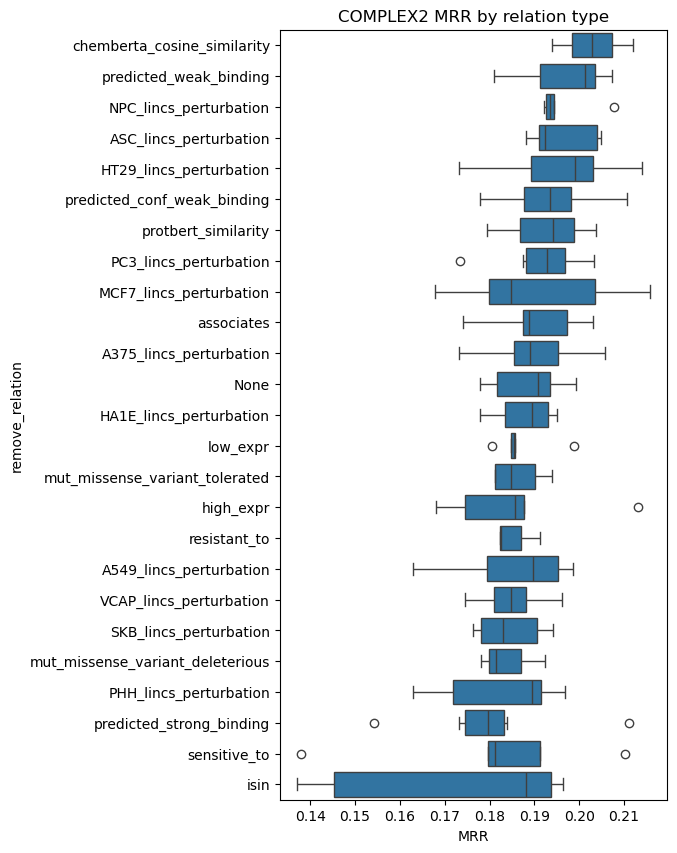

In [216]:
plt.figure(figsize=(5, 10)) 
plt.title(f'COMPLEX2 {target_metric} by relation type')
sbn.boxplot(y='remove_relation', x=target_metric, data=all_cpx, order=all_cpx.groupby('remove_relation')[[target_metric]].mean().sort_values(by=target_metric, ascending=False).index.tolist())
plt.show()

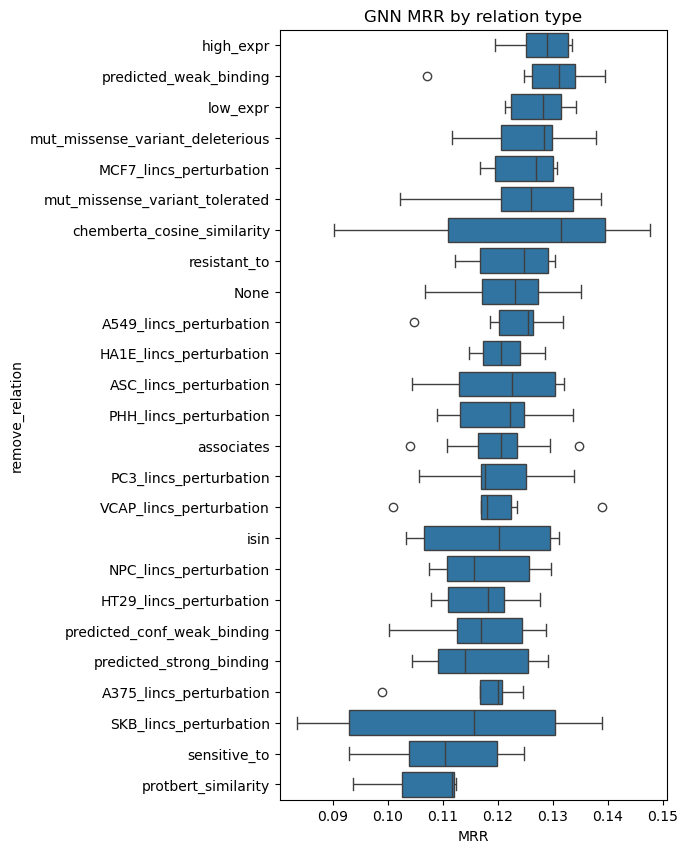

In [217]:
plt.figure(figsize=(5, 10)) 
plt.title(f'GNN {target_metric} by relation type')
sbn.boxplot(y='remove_relation', x=target_metric, data=all_gnn, order=all_gnn.groupby('remove_relation')[[target_metric]].mean()\
            .sort_values(by=target_metric, ascending=False).index.tolist())
plt.show()

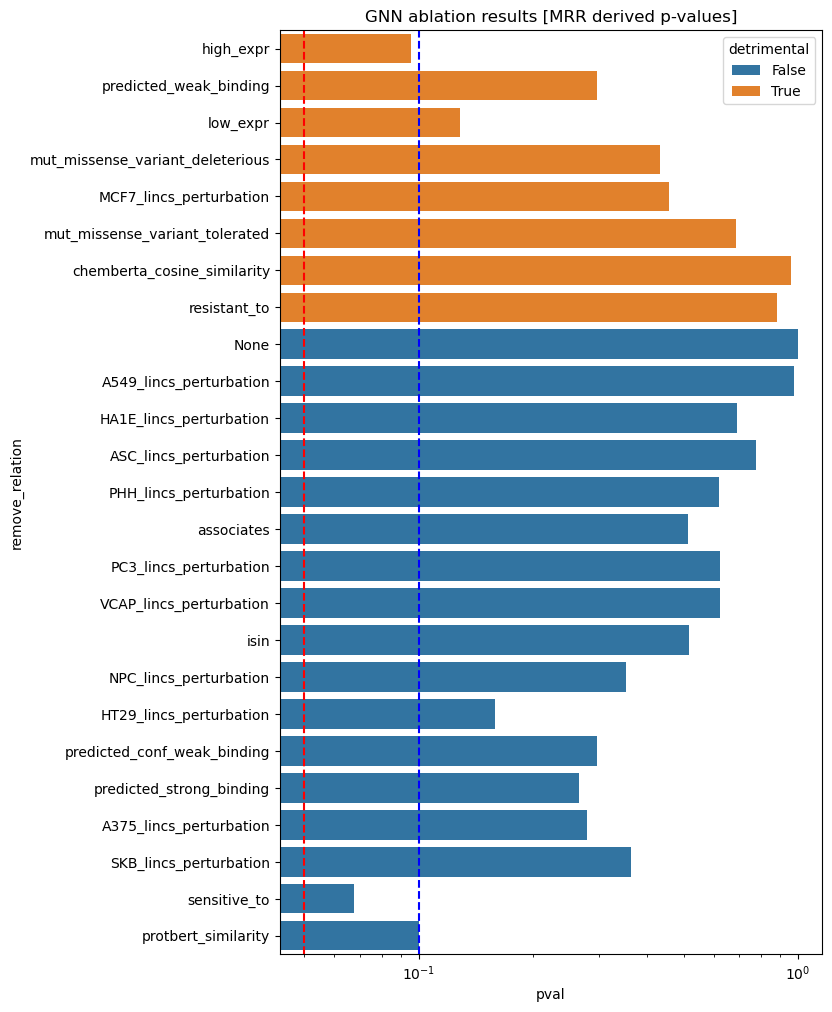

In [218]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'GNN'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--', label='0.05')
plt.axvline(0.1, color='blue', linestyle='--', label='0.1')
plt.title(f'GNN ablation results [{target_metric} derived p-values]')
plt.show()

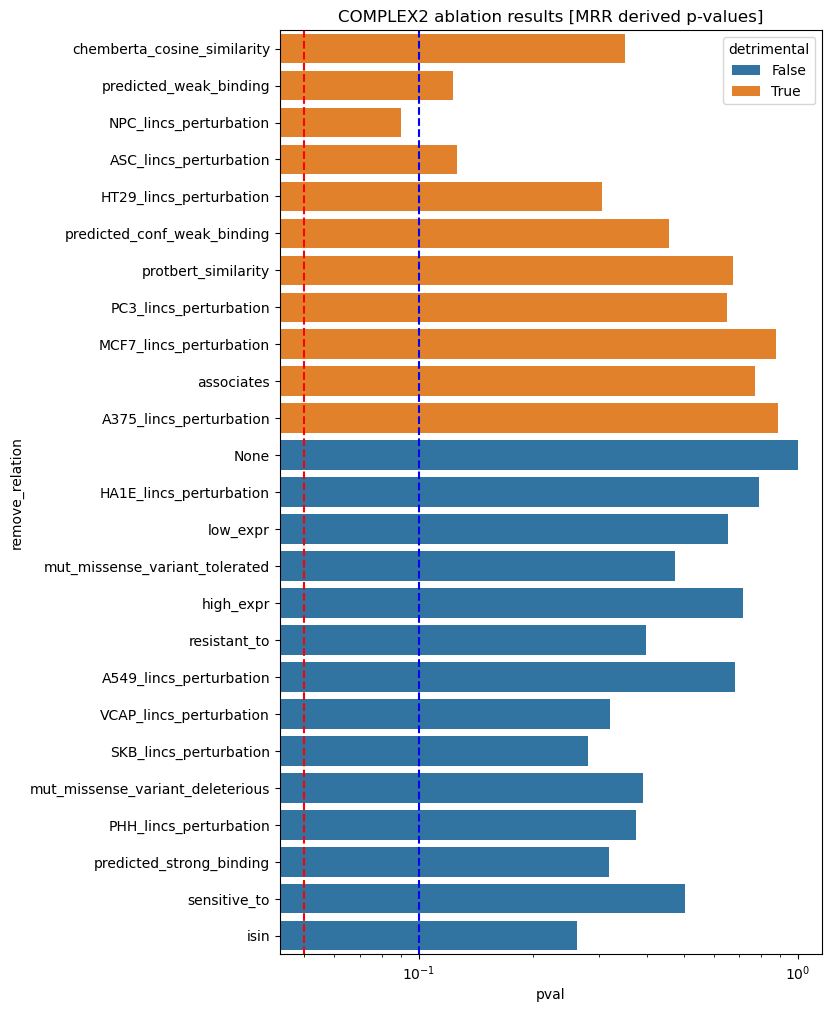

In [219]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x='pval', y='remove_relation', hue='detrimental', data=res[lambda x: x.model == 'COMPLEX2'].reset_index())
plt.xscale('log')
plt.axvline(0.05, color='red', linestyle='--')
plt.axvline(0.1, color='blue', linestyle='--', label='0.1')
plt.title(f'COMPLEX2 ablation results [{target_metric} derived p-values]')
plt.show()

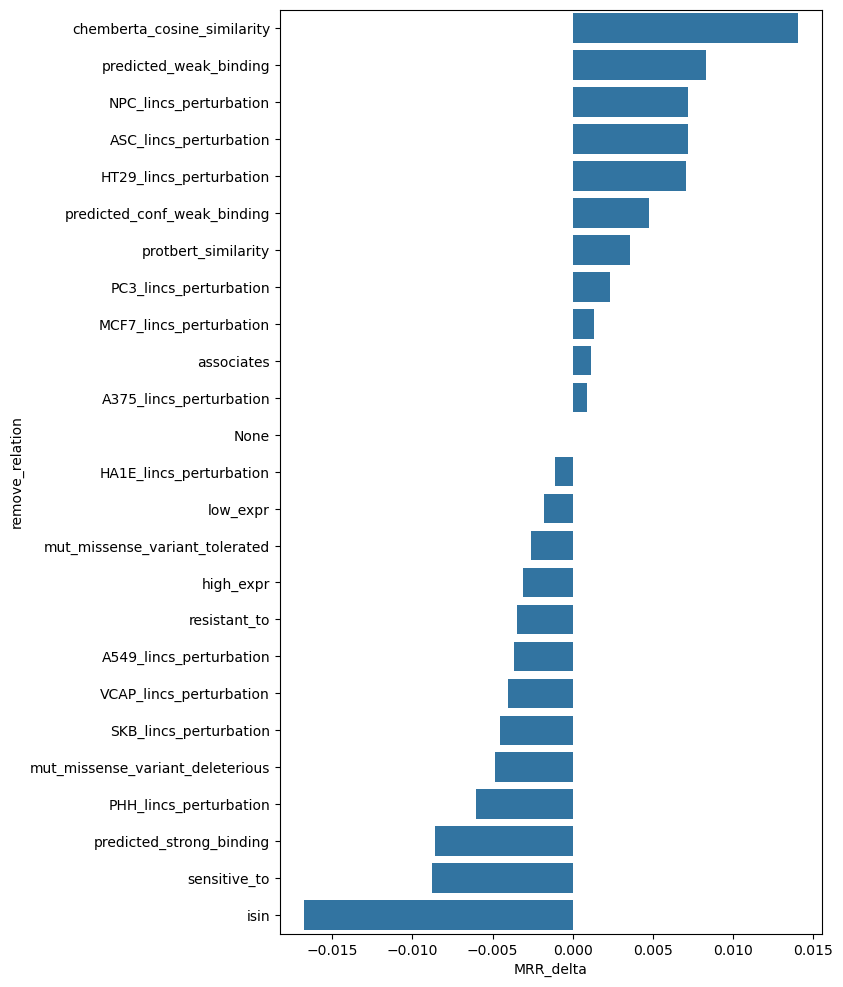

In [220]:
plt.figure(figsize=(7,12)) 
sbn.barplot(x=f'{target_metric}_delta', y='remove_relation', data=res[lambda x: x.model == 'COMPLEX2'])
plt.show()

In [221]:
res = res.assign(reverse_edge = lambda x: x.remove_relation.str.contains('_rev-'))

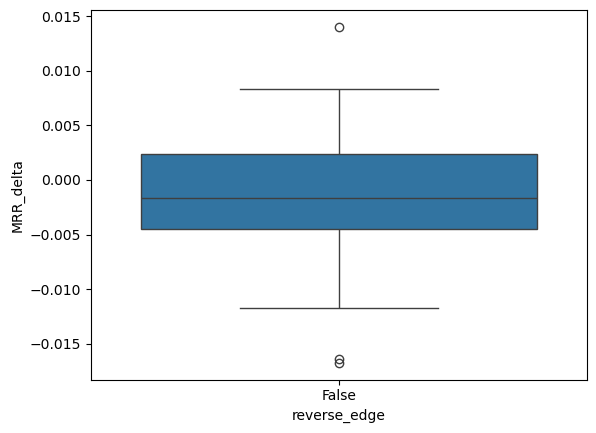

In [222]:
plt.figure()
sbn.boxplot(x='reverse_edge', y=f'{target_metric}_delta', data=res)
plt.show()

In [223]:
all_cpx.sort_values(by=target_metric, ascending=False).head(1)

,optim,lr,wd,channels,batch_size,n_epochs,lr_scheduler,dropout,remove_relation_idx,MRR,Top1,Top3,Top10,Top100,avg_AUC,avg_AP,avg_Brier,ECE,uid,remove_relation
9,adam,0.001,0.000001,512,5000,100,False,0.0,8.0,0.215714,0.140496,0.231405,0.355372,0.706612,0.955665,0.335811,0.109298,0.283145,b2e49246-9cc3-49b3-b0bb-3832605cd5ec,MCF7_lincs_perturbation


In [224]:
all_gnn.sort_values(by=target_metric, ascending=False).head(1)

,model,lr,wd,channels,batch_size,n_epochs,layers,num_workers,nonlin,heads,...,Top1,Top3,Top10,Top100,avg_AUC,avg_AP,avg_Brier,ECE,uid,remove_relation
140,path-gnn,0.01,1.000000e-07,16,5,100,4,10,elu,2,...,0.099174,0.14876,0.219008,0.661157,0.967878,0.198386,0.000254,0.000151,af5f4101-1cd9-48de-bb96-63d9aaba9878,chemberta_cosine_similarity


In [119]:
res_wide = res.pivot(index='remove_relation', columns='model', values='MRR_delta')
res_wide = res_wide.assign(avg=res_wide.mean(axis=1))
res_wide = res_wide.sort_values(by='avg', ascending=False)
res_wide.head(15)

model,COMPLEX2,GNN,avg
remove_relation,,,
drug->HA1E_lincs_perturbation_fwd->gene,0.013057,0.006583,0.009820
drug->predicted_weak_binding_fwd->gene,0.012339,0.006370,0.009355
gene->mut_missense_variant_deleterious_rev->dbgap_subject,0.006066,0.007768,0.006917
dbgap_subject->resistant_to_fwd->drug,0.011737,0.001138,0.006437
gene->associates_fwd->disease,-0.005550,0.012937,0.003693
dbgap_subject->mut_missense_variant_deleterious_fwd->gene,0.001975,0.005259,0.003617
gene->mut_missense_variant_tolerated_rev->dbgap_subject,-0.000813,0.006494,0.002841
dbgap_subject->low_expr_fwd->gene,-0.005280,0.009672,0.002196
drug->PC3_lincs_perturbation_fwd->gene,0.008144,-0.006170,0.000987


In [120]:
res_wide.tail(20)

model,COMPLEX2,GNN,avg
remove_relation,,,
drug->predicted_conf_weak_binding_fwd->gene,-0.002353,-0.011362,-0.006858
gene->high_expr_rev->dbgap_subject,-0.011815,-0.002129,-0.006972
drug->MCF7_lincs_perturbation_fwd->gene,-0.012747,-0.001458,-0.007103
dbgap_subject->high_expr_fwd->gene,-0.017367,0.001577,-0.007895
drug->resistant_to_rev->dbgap_subject,-0.012609,-0.003519,-0.008064
drug->HT29_lincs_perturbation_fwd->gene,-0.008439,-0.008191,-0.008315
gene->PC3_lincs_perturbation_rev->drug,-0.007967,-0.009162,-0.008565
gene->SKB_lincs_perturbation_rev->drug,-0.001531,-0.016404,-0.008967
disease->associates_rev->gene,-0.014670,-0.006376,-0.010523


COMPLEX-GNN MRR DELTAS CORR 0.24622448979591838


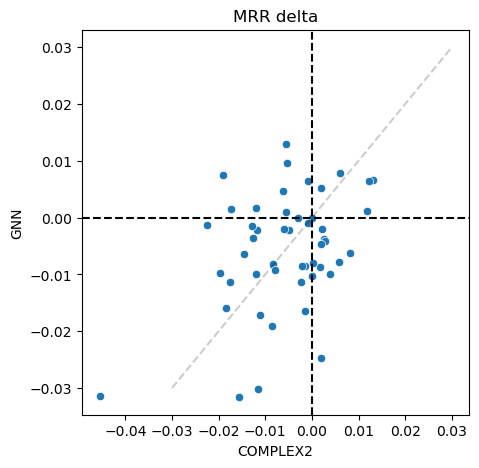

In [121]:
r = res_wide.corr(method='spearman').values[0,1]
print('COMPLEX-GNN MRR DELTAS CORR', r)

plt.figure(figsize=(5,5))
sbn.scatterplot(x='COMPLEX2', y='GNN', data=res_wide.reset_index())
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.plot([-0.03, 0.03], [-0.03, 0.03], color='black', linestyle='--', alpha =0.2)
plt.title('MRR delta')
plt.show()


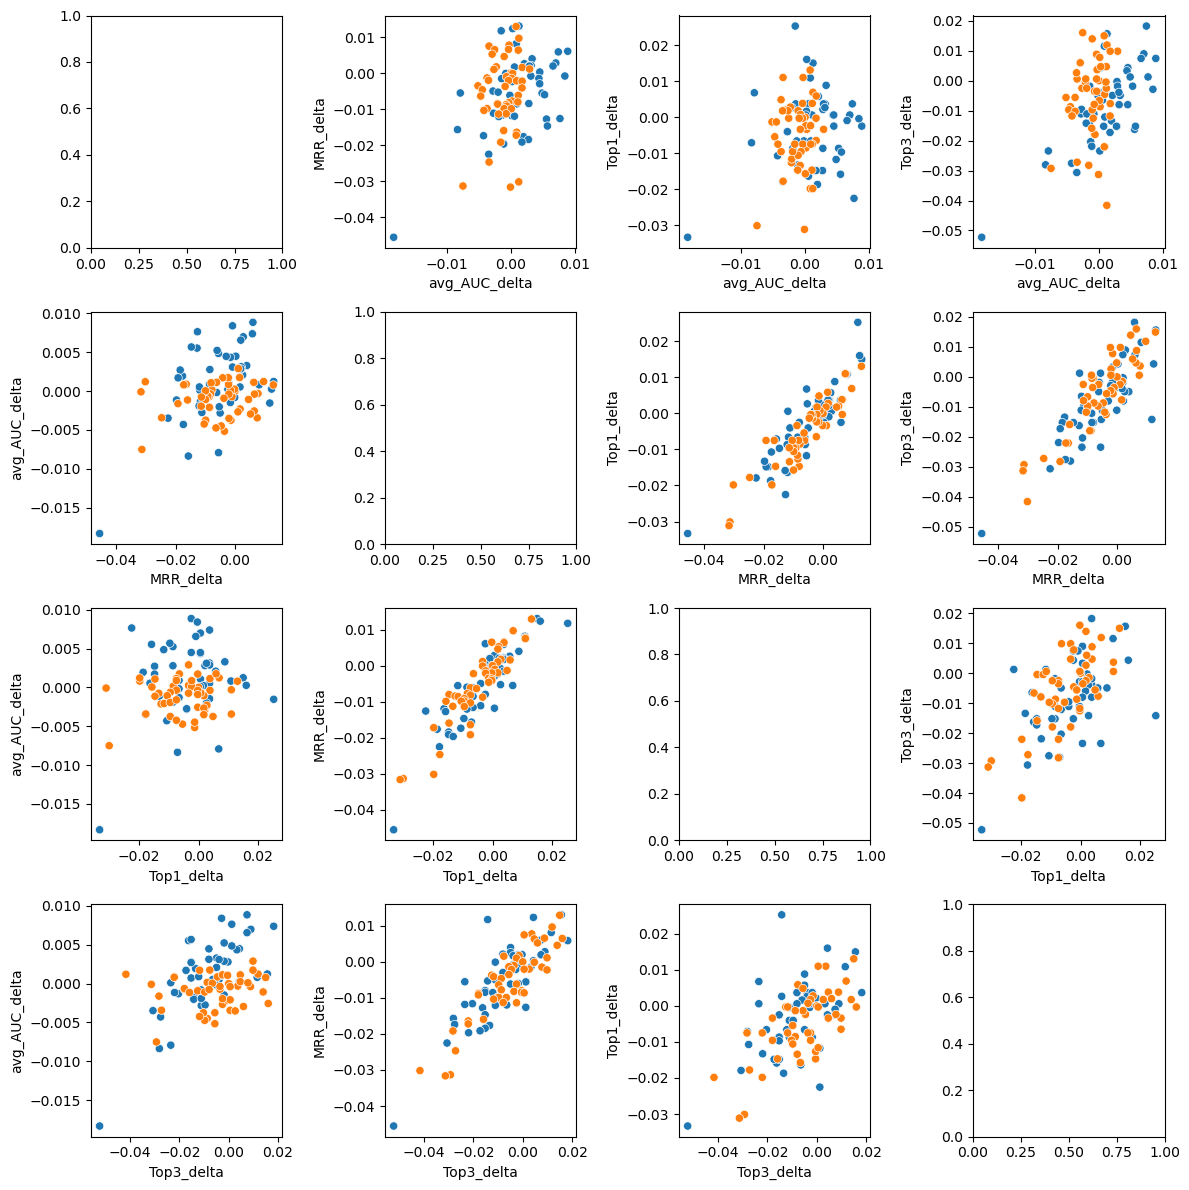

In [122]:

f,axes = plt.subplots(4,4, figsize=(12,12))


for i,xx in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
    for j, yy in enumerate(['avg_AUC_delta', 'MRR_delta', 'Top1_delta', 'Top3_delta']):
        if xx == yy:
            continue

        sbn.scatterplot(x=xx, y=yy, hue='model', data=res, ax=axes[i,j], legend=False)

plt.tight_layout()
plt.show()



In [123]:


# ttest 

# remove sig detrimental relations 

# run hparam tuning 

# prepare results for anupriya 